## Multivariate distribution - exercise 

As in the previous exercise, in this study we are going to perform some multivariate distribution analysis using a different dataset. 

In this exercise we are going to understand how the berthing speed of a ship is correlated with other ship's parameters. 

Let's first import the required libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import multivariate_normal
from scipy.stats import norm
import datetime

%matplotlib inline

Now it's time to load the data and display them.

In [27]:
df = pd.read_csv('016_vessel_berthing.csv')
df

,Datetime,Berthing angle (degrees),Berthing speed (cm/s),Vessel displacement (tonnes)
0,14/11/11 12:20,1.1,10,8312
1,31/10/11 11:45,-1.1,6,8616
2,14/11/11 10:45,0.8,7,10004
3,31/10/11 12:15,-1.0,7,10298
4,11/11/11 10:30,0.7,9,10531
...,...,...,...,...
172,8/12/11 11:18,0.1,2,197585
173,26/10/11 07:30,0.2,2,197585
174,30/11/11 16:42,0.1,1,197585
175,29/10/11 00:15,0.3,1,243652


Just for your knowledge, the berthing speed $v_n \hspace{0.75mm}(cm/s)$ is the speed that ships have when they approach a berthing structure in a port. The vessel displacement $d_{vessel} \hspace{0.75mm}(tonnes)$ is the weight of the ship, including cargo, passengers, fuel and so on, while the berthing angle $\alpha \hspace{0.75mm}(degrees)$ is the approach angle formed by the fender line and the longitudinal axis of the vessel. 

In [28]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

We can also display the first entries of the DataFrame as well as the main statistics.

In [29]:
df.head()

,Datetime,Berthing angle (degrees),Berthing speed (cm/s),Vessel displacement (tonnes)
0,2011-11-14 12:20:00,1.1,10,8312
1,2011-10-31 11:45:00,-1.1,6,8616
2,2011-11-14 10:45:00,0.8,7,10004
3,2011-10-31 12:15:00,-1.0,7,10298
4,2011-11-11 10:30:00,0.7,9,10531


In [30]:
df.describe()

,Berthing angle (degrees),Berthing speed (cm/s),Vessel displacement (tonnes)
count,177.000000,177.000000,177.000000
mean,0.174576,3.937853,85413.977401
std,0.424235,2.185069,58452.631527
min,-1.400000,1.000000,8312.000000
25%,0.100000,2.000000,26595.000000
50%,0.200000,4.000000,81021.000000
75%,0.400000,5.000000,138807.000000
max,1.500000,10.000000,250603.000000


We now plot the data.

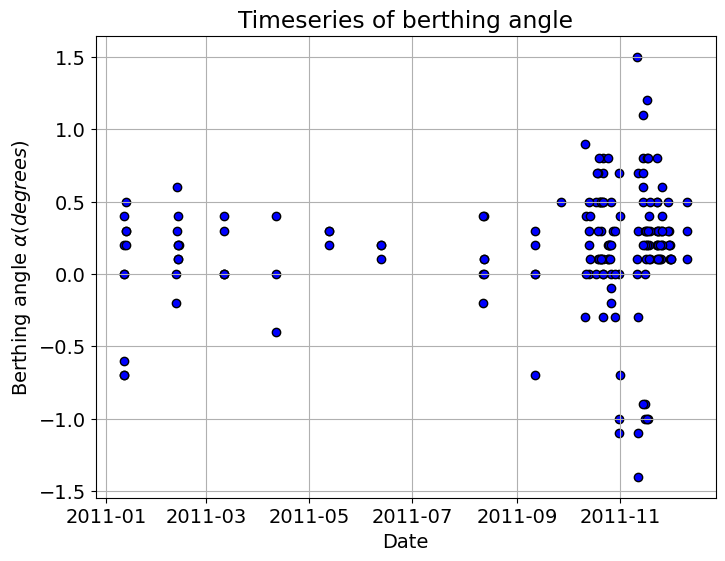

In [31]:
plt.figure(figsize=(8,6))
plt.scatter(df['Datetime'], df['Berthing angle (degrees)'], color='blue',edgecolor='k')
plt.xlabel('Date')
plt.ylabel(r'Berthing angle $\alpha (degrees)$')
plt.title('Timeseries of berthing angle')
plt.grid()

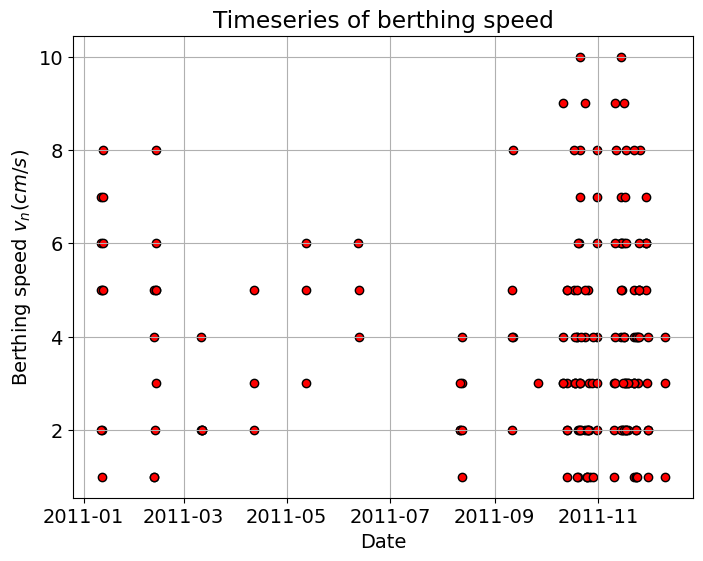

In [32]:
plt.figure(figsize=(8,6))
plt.scatter(df['Datetime'], df['Berthing speed (cm/s)'], color='red', edgecolor='k')
plt.xlabel('Date')
plt.ylabel(r'Berthing speed $v_n (cm/s)$')
plt.title('Timeseries of berthing speed')
plt.grid()

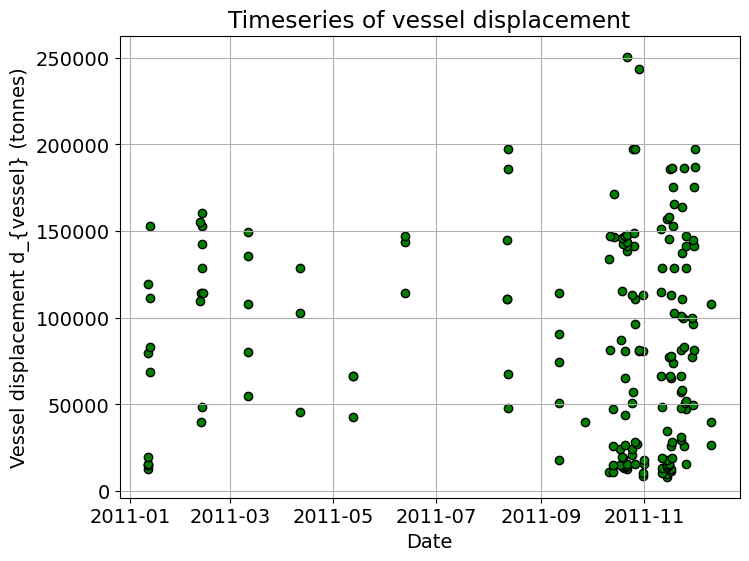

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(df['Datetime'], df['Vessel displacement (tonnes)'], color='green',edgecolor='k')
plt.xlabel('Date')
plt.ylabel(r'Vessel displacement d_{vessel} (tonnes)')
plt.title('Timeseries of vessel displacement')
plt.grid()

#### Univariate analysis

We can also plot one variable against another to see if there's a correlation among them.
\
We will do it for the berthing speed and the vessels displacement and we will include the marginal distribution of both variables.

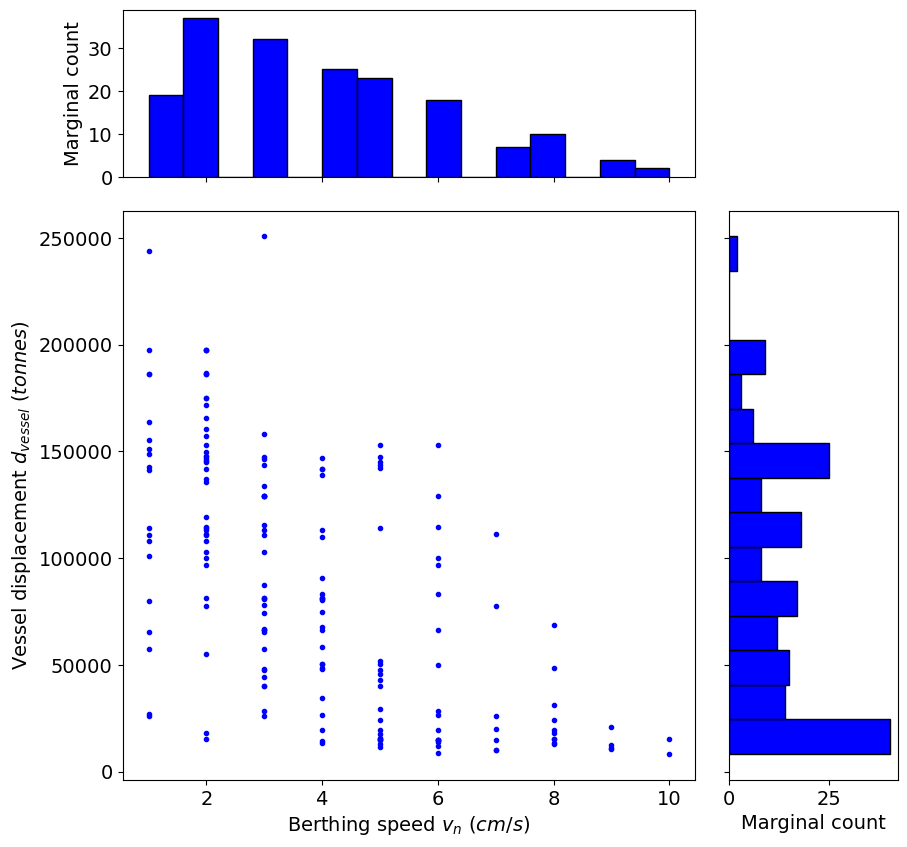

In [34]:
fig = plt.figure(figsize=(10,10))

gs = gridspec.GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(df['Berthing speed (cm/s)'], df['Vessel displacement (tonnes)'], marker='.', color='blue')
ax_marg_x.hist(df['Berthing speed (cm/s)'], bins=15, align='mid', color='blue', edgecolor='k')
ax_marg_y.hist(df['Vessel displacement (tonnes)'], bins=15, orientation='horizontal', align='mid', color='blue', edgecolor='k')

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel(r'Berthing speed $v_n$ $(cm/s)$')
ax_joint.set_ylabel(r'Vessel displacement $d_{vessel}$ $(tonnes)$')

# Set labels on marginals
ax_marg_y.set_xlabel('Marginal count')
ax_marg_x.set_ylabel('Marginal count')
plt.show()

By simply looking at the previous plot it seems that a negative trend appears, which means that for larger values of the berthing speed generally lower values of the vessel displacement occur (and viceversa). Let's see if that's proven by means of covariance and correlation. 

We now define two functions to calculate the covariance $Cov$ and the Pearson correlation coefficient $\rho$.

In [35]:
def calculate_covariance(X1, X2):
    '''
    Calculate the covariance of two random variables X1 and X2
    '''
    mean_x1 = np.mean(X1)
    mean_x2 = np.mean(X2)
    diff_x1 = [item-mean_x1 for item in X1]
    diff_x2 = [item-mean_x2 for item in X2]
    product = [a*b for a,b in zip(diff_x1,diff_x2)]
    covariance = np.mean(product)
    return covariance

def pearson_correlation(X1, X2):
    '''
    Calculate the Pearson correlation coefficient of two random variables X1 and X2
    '''
    covariance = calculate_covariance(X1, X2)
    correl_coeff = covariance/(np.std(X1)*np.std(X2))
    return correl_coeff

In [36]:
covariance = calculate_covariance(df['Berthing speed (cm/s)'], df['Vessel displacement (tonnes)'])
print(f'The covariance of berthing speed and vessel displacement is {covariance:.5f}')

The covariance of berthing speed and vessel displacement is -77104.44773


In [37]:
correl_coeff = pearson_correlation(df['Berthing speed (cm/s)'], df['Vessel displacement (tonnes)'])
print(f'The correlation coefficient of berthing speed and vessel displacement is {correl_coeff:.5f}')

The correlation coefficient of berthing speed and vessel displacement is -0.60711


As we can see, differently from the previous case study, the correlation coefficient between the berthing speed and the vessel displacement is negative. Even though it's not really close to $\rho=-1$, it still shows that there is a kind of negative linear relationship between the variables.

#### Multivariate analysis

We can also perform a multivariate analysis by creating the $\mu$ vector and $\Sigma$ matrix.

In [38]:
mu1 = np.mean(df['Berthing speed (cm/s)'])
mu2 = np.mean(df['Vessel displacement (tonnes)'])
mu = np.array([mu1, mu2])

sigma1 = np.std(df['Berthing speed (cm/s)'])
sigma2 = np.std(df['Vessel displacement (tonnes)'])

rho = correl_coeff

sigma = np.array([[sigma1**2, covariance], [covariance, sigma2**2]])

print(f'\u03BC = {mu}')
print(f'\u03A3 = {sigma}')

μ = [3.93785311e+00 8.54139774e+04]
Σ = [[ 4.74755019e+00 -7.71044477e+04]
 [-7.71044477e+04  3.39740669e+09]]


Now we create two vectors for evaluating the berthing speed and the vessel displacement.

In [39]:
n = 50 #size of the mesh
eval_speed = np.linspace(mu[0]-1.5*sigma1, mu[0]+3.8*sigma1, n)
eval_displacement = np.linspace(mu[1]-3.8*sigma1, mu[1]+3.8*sigma2, n)

X1,X2 = np.meshgrid(eval_speed, eval_displacement)
X = np.array([np.concatenate(X1.T), np.concatenate(X2.T)]).T

Now it's time to fit the normal distribution to the data and then plot it.

In [40]:
Z = multivariate_normal(mean=mu, cov=sigma).pdf(X)

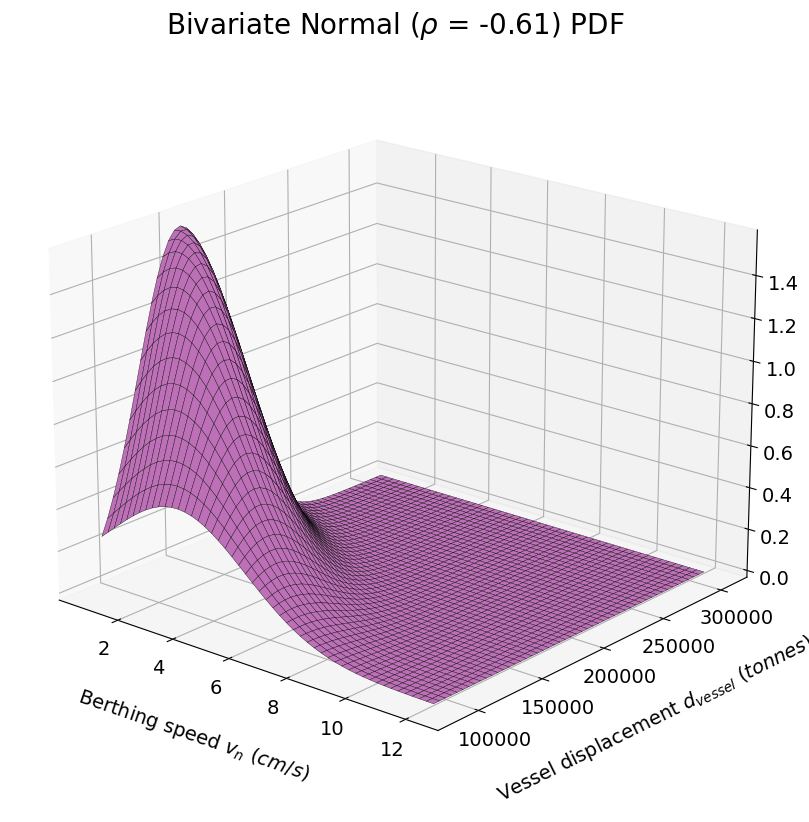

In [41]:
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z.reshape(X1.shape), color='#F792EF', edgecolor='black', linewidth=.25)
ax.set_xlabel(r'Berthing speed $v_n$ $(cm/s)$',labelpad=20)
ax.set_ylabel(r'Vessel displacement $d_{vessel}$ $(tonnes)$',labelpad=20)
ax.set_zlabel('$f(x_1,x_2)$',labelpad=20)
ax.set_title(f'Bivariate Normal ($\\rho$ = {round(rho, 2)}) PDF', fontsize=20)
ax.view_init(ax.elev-10, ax.azim+10)
plt.show()

We can also determine the Cumulative Distribution Function (CDF) of the same vector and then plot the result.

In [42]:
p = multivariate_normal(mean=mu, cov=sigma).cdf(X)

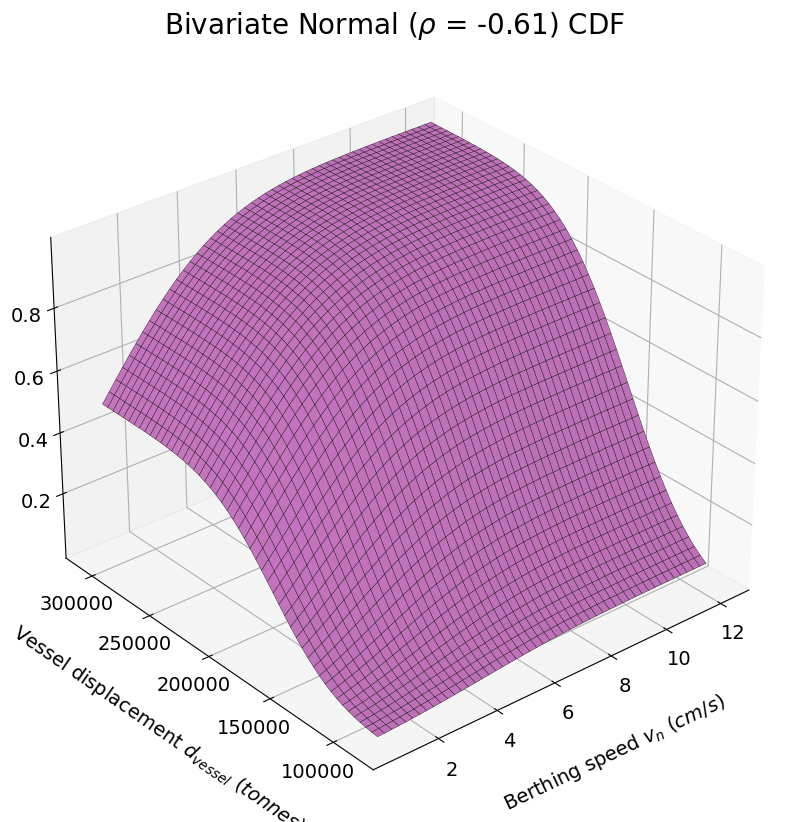

In [43]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, p.reshape(X1.shape), color='#F792EF', edgecolor='black', linewidth=.25)
ax.set_xlabel(r'Berthing speed $v_n$ $(cm/s)$',labelpad=20)
ax.set_ylabel(r'Vessel displacement $d_{vessel}$ $(tonnes)$',labelpad=20)
ax.set_zlabel('$P(X_1 \leq x_1, X_2 \leq x_2)$',labelpad=20)
ax.set_title(f'Bivariate Normal ($\\rho$ = {round(rho, 2)}) CDF', fontsize=20)
ax.view_init(ax.elev, ax.azim-70)
plt.show()

#### Multivariate conditional probability

In case the value of one of the two variables is known we can apply apply the Multivariate Conditional Probability Distribution and see how it changes with respect to the original Multivariate Distribution. 

This exercise will be performed only for the 2D example of this case study. For the 3D example please refer to the other exercise (Multivariate distribution). 

Remember that for a 2D Conditional Distribution, both $\mu$ and $\Sigma$ are scalars and no longer a vector and a matrix, respectively. 

We start defining the function that will calculate the Conditional Normal Distribution. 

In [44]:
def ConditionalNormal(M, S, idxC, valC):
    """
    CondionalNormal calculates the parameters of the conditional 
    normal distribution
    
    Parameters
    ----------
    M : numpy.ndarray
        Mean vector of the multivariate normal
    S : numpy.ndarray
        Covariance matrix of the multivariate normal
    idxC : list
        Index/Indices of the conditioning nodes
    valC : numpy.ndarray
        Values of the conditioning nodes
        
    Returns
    -------
    Mc : numpy.ndarray
        Mean vector of the conditional multivariate normal on valC
    Sc : numpy.ndarray
        Covariance matrix of the conditional multivariate normal valC
    """
    if not isinstance(M,np.ndarray):
        M = np.array(M)
    D = len(M)  # Dimension of the multivariate normal
    idxNC = list(list(set(range(D)) - set(idxC)))
    # Calculation of the conditional normal distribution:
    M1 = M[idxNC]
    S11 = S[np.ix_(idxNC, idxNC)]
    X2 = valC
    M2 = M[idxC]
    S22 = S[np.ix_(idxC, idxC)]
    S12 = S[np.ix_(idxNC, idxC)]
    S21 = S[np.ix_(idxC, idxNC)]
    S22_inv = np.linalg.inv(S22)

    Sc = S11 - S12 @ S22_inv @ S21
    Mc = M1 + S12 @ S22_inv @ (X2 - M2)
    return Mc, Sc

Then we need to specify the index of the conditioning variable and its value and finally we compute the conditional distribution.

In this case we set the berthing speed equal to $s_{b}=2.5 \hspace{0.75mm} cm/s$.

In [45]:
idxC = [0] 
valC = 2.5 

[Mc, Sc] = ConditionalNormal(mu, sigma, idxC ,valC)

Now it's time to compute the marginal and conditional distribution of the second variable and then plot it.

In [46]:
po = norm.cdf(eval_displacement, mu[1], sigma2)
poc = norm.cdf(eval_displacement, Mc, Sc**0.5).reshape(po.shape)

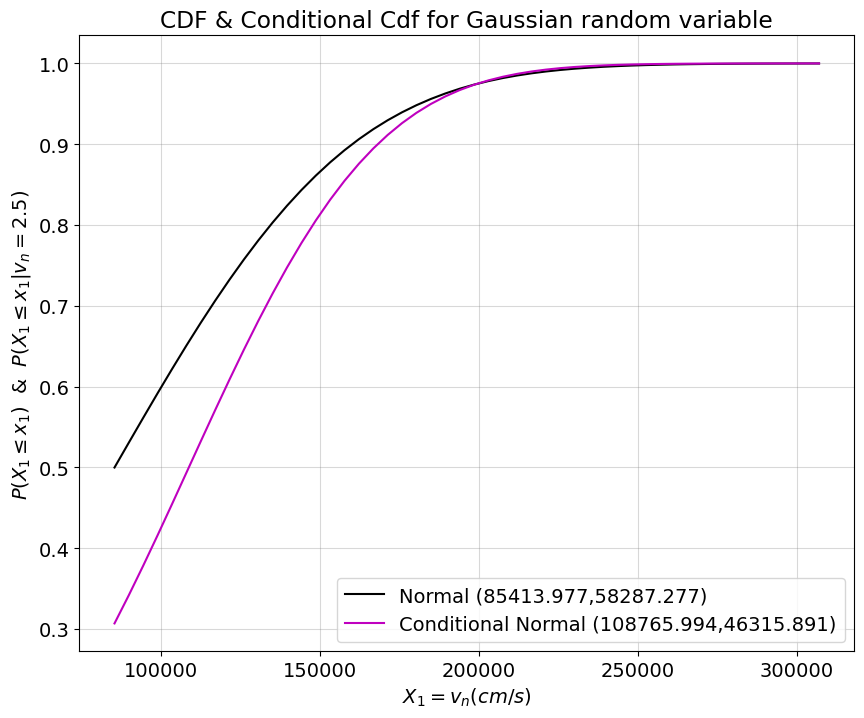

In [47]:
plt.figure(figsize=(10,8))
plt.plot(eval_displacement, po, 'k', label = f'Normal ({np.round(mu[1], 3)},{np.round(sigma2, 3)})' )
plt.plot(eval_displacement, poc,'m', label = f'Conditional Normal ({np.round(Mc[0],3)},{np.round(Sc[0][0]**.5,3)})')
plt.xlabel(f'$X_1 = v_n (cm/s)$')
plt.ylabel(f'$P(X_1 \leq x_1)$  &  $P(X_1 \leq x_1|v_n = {valC})$')
plt.title('CDF & Conditional Cdf for Gaussian random variable')
plt.grid('--', color='gray', alpha=.3)
plt.legend(loc='lower right')
plt.show()

You can repeat the same exercise but choosing a different set of variables, for instance the berthing angle together with the berthing speed or the berthing angle and the vessel displacement. 